In [6]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

data_dir = "./data"

device = torch.device("cpu")

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")

if torch.cuda.is_available():
    device = torch.device("cuda")

print(f"Data resides in        : {data_dir}")
print(f"Training model on      : {str(device)}")

Data resides in        : ./data
Training model on      : mps


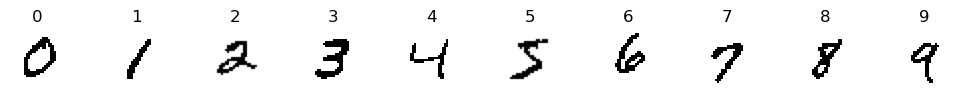

In [7]:
def print_samples(samples, elements_per_row=10, fig_width=10, cmap="binary"):
    num_digits = len(samples)
    num_rows = (num_digits + elements_per_row - 1) // elements_per_row

    plt.figure(figsize=(fig_width, fig_width / elements_per_row * num_rows))
    for idx, (label, image) in enumerate(samples):
        plt.subplot(num_rows, elements_per_row, idx + 1)
        plt.imshow(image.squeeze(), cmap=cmap)
        plt.title(label, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# load MNIST and convert it to binary directly in transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),               # normalize to [0, 1]
    transforms.Lambda(lambda x: (x > 0.5).float())  # binarize
])

train_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

sample_list = [(label, next(image for image, lbl in train_dataset if lbl == label)) for label in range(10)]
print_samples(sample_list)

In [19]:
class RBM(nn.Module):
    def __init__(self, visible_dim, hidden_dim=128, W_var=0.01, a_val=0.0, b_val=0.0):
        super().__init__()
        self.W = nn.Parameter(torch.randn(visible_dim, hidden_dim) * W_var)
        self.a = nn.Parameter(torch.full((visible_dim,), a_val))
        self.b = nn.Parameter(torch.full((hidden_dim,), b_val))

    def sample_hidden(self, v):
        h_probs = torch.sigmoid(v @ self.W + self.b)
        h_sample = torch.bernoulli(h_probs)
        return h_probs, h_sample

    def sample_visible(self, h):
        v_probs = torch.sigmoid(h @ self.W.t() + self.a)
        v_sample = torch.bernoulli(v_probs)
        return v_probs, v_sample

    def sample_gibbs(self, v0_sample, k=1):
        # we need to be careful not to run out of synch

        vk_probs, vk_sample = v0_sample.clone(), torch.zeros(v0_sample.size())
        hk_probs, hk_sample = self.sample_hidden(v0_sample)

        for _ in range(k):
            vk_probs, vk_sample = self.sample_visible(hk_sample)
            hk_probs, hk_sample = self.sample_hidden(vk_sample)

        return hk_probs, hk_sample, vk_probs, vk_sample

    def contrastive_divergence(self, v0_sample, k=1, lr=0.01):
        # positive phase
        h0_probs, h0_sample = self.sample_hidden(v0_sample)

        # negative phase
        hk_probs, _, vk_probs, vk_sample = self.sample_gibbs(v0_sample, k)

        # calculate associations (batch_dim vanishes during matrix multiplication)
        batch_size = v0_sample.size(0)
        positive_association = (v0_sample.T @ h0_probs) / batch_size
        negative_association = (vk_sample.T @ hk_probs) / batch_size

        # parameter step
        self.W.data += lr * (positive_association - negative_association)
        self.a.data += lr * (v0_sample.mean(dim=0) - vk_sample.mean(dim=0))
        self.b.data += lr * (h0_probs.mean(dim=0) - hk_probs.mean(dim=0))

        return vk_sample

In [73]:
hidden_dim = 2048
batch_size = 256
epochs = 100
lr = 0.01
gibbs_steps = 1


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


visible_dim = train_dataset[0][0].numel()
rbm = RBM(visible_dim, hidden_dim).to(device)


metrics = {}
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch, _ in train_loader:
        flat_batch = batch.view(-1, visible_dim).to(device)

        recon_batch = rbm.contrastive_divergence(flat_batch, k=gibbs_steps)

        loss = torch.mean(torch.sum((flat_batch - recon_batch) ** 2, dim=1))
        epoch_loss += loss.item()

    metrics[epoch] = { "reconstruction_error": epoch_loss / len(train_loader) }
    print(f"Epoch {epoch + 1}/{epochs} : Loss {metrics[epoch]['reconstruction_error']:.4f}")

Epoch 1/100 : Loss 129.2358
Epoch 2/100 : Loss 100.9519
Epoch 3/100 : Loss 86.3319
Epoch 4/100 : Loss 78.2205
Epoch 5/100 : Loss 72.4129
Epoch 6/100 : Loss 67.8588
Epoch 7/100 : Loss 64.1691
Epoch 8/100 : Loss 61.1298
Epoch 9/100 : Loss 58.4700
Epoch 10/100 : Loss 56.2489
Epoch 11/100 : Loss 54.2756
Epoch 12/100 : Loss 52.5223
Epoch 13/100 : Loss 50.9541
Epoch 14/100 : Loss 49.5628
Epoch 15/100 : Loss 48.2811
Epoch 16/100 : Loss 47.1416
Epoch 17/100 : Loss 46.1007
Epoch 18/100 : Loss 45.1179
Epoch 19/100 : Loss 44.2411
Epoch 20/100 : Loss 43.3915
Epoch 21/100 : Loss 42.6207
Epoch 22/100 : Loss 41.9546
Epoch 23/100 : Loss 41.2598
Epoch 24/100 : Loss 40.5997
Epoch 25/100 : Loss 40.0264
Epoch 26/100 : Loss 39.4395
Epoch 27/100 : Loss 38.9551
Epoch 28/100 : Loss 38.4241
Epoch 29/100 : Loss 37.9384
Epoch 30/100 : Loss 37.5029
Epoch 31/100 : Loss 37.0717
Epoch 32/100 : Loss 36.6341
Epoch 33/100 : Loss 36.2387
Epoch 34/100 : Loss 35.8660
Epoch 35/100 : Loss 35.5250
Epoch 36/100 : Loss 35.1471

Text(0, 0.5, 'Reconstruction Error')

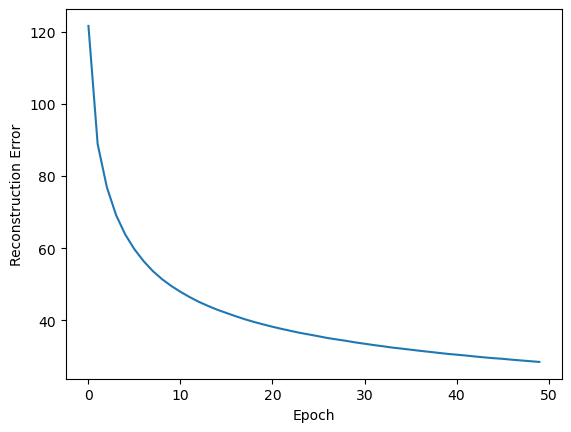

In [41]:
# only plot the reconstruction_error
plt.plot([metrics[epoch]['reconstruction_error'] for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")

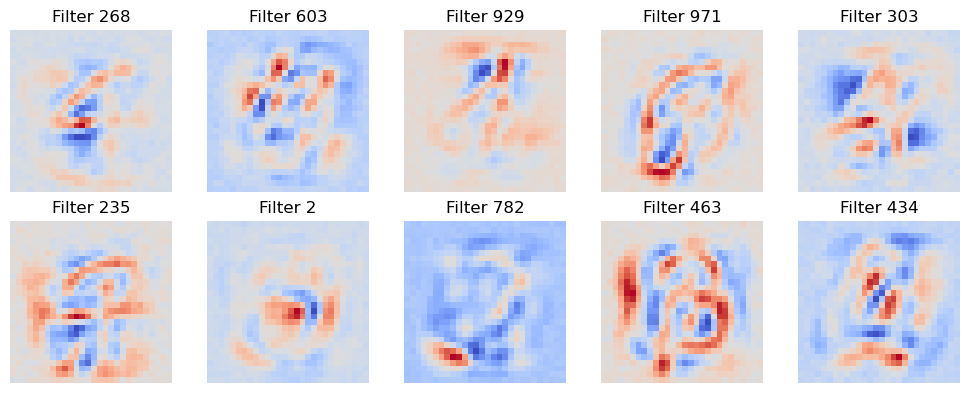

In [43]:
# the weights have shape (visible_dim, hidden_dim), we can transpose to get some kind of filter view for the hidden ones
hidden_columns = rbm.W.t().detach().cpu().view(hidden_dim, 28, 28)
filter_idx = torch.randint(0, hidden_dim, (10,))
filter_samples = [(f"Filter {idx.item()}", hidden_columns[idx]) for idx in filter_idx]
# use height map color scheme blue red
print_samples(filter_samples, elements_per_row=5, cmap="coolwarm")

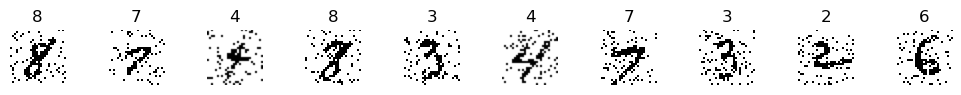

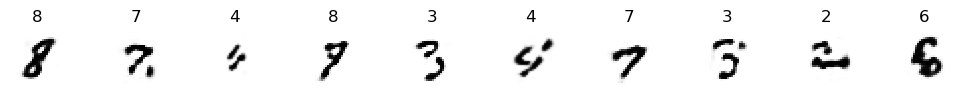

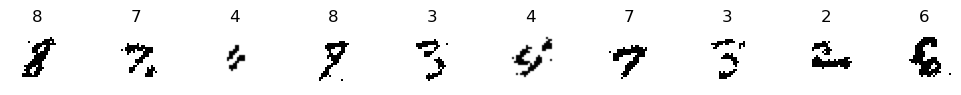

In [72]:
# getting some random samples with noise
random_labels = torch.randint(0, 10, (10,))
noise_level = 0.1

demo_samples = []
label_idx = 0

for image, lbl in train_dataset:
    if label_idx >= len(random_labels):
        break

    if lbl == random_labels[label_idx]:
        demo_samples.append((lbl, image))

        noise = torch.rand_like(image)
        image[noise < noise_level] = 1 - image[noise < noise_level]

        label_idx += 1


# performing reconstruction
demo_recon_probs = []
demo_recon_samples = []
with torch.no_grad():
    for digit, sample in demo_samples:
        flat_sample = sample.view(-1, visible_dim).to(device)

        _, _, v_probs, v_sample = rbm.sample_gibbs(flat_sample, k=10)

        demo_recon_probs.append((digit, v_probs.view(28, 28).cpu()))
        demo_recon_samples.append((digit, v_sample.view(28, 28).cpu()))


inverted_demo_recon_probs = [(digit, 1 - v_prob) for digit, v_prob in demo_recon_probs]

print_samples(demo_samples, elements_per_row=10, cmap="binary")
print_samples(inverted_demo_recon_probs, elements_per_row=10, cmap="gray")
print_samples(demo_recon_samples, elements_per_row=10, cmap="binary")

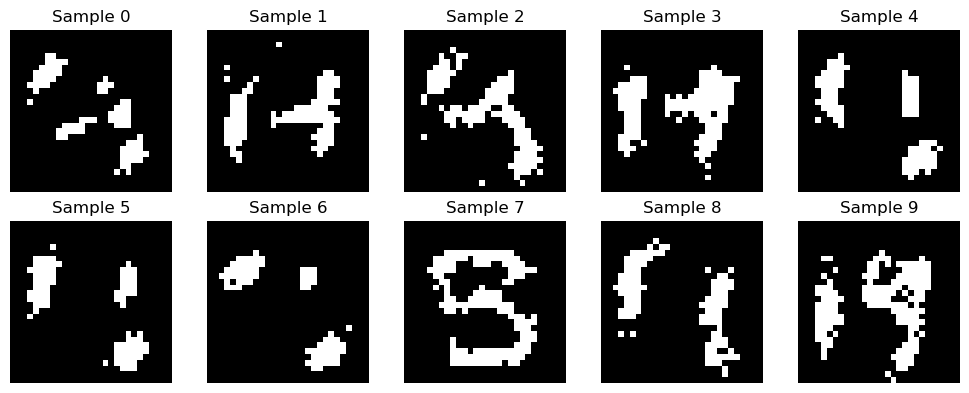

In [70]:
# generation starting from random noise
generation_steps = 30

with torch.no_grad():
    random_samples = torch.bernoulli(torch.rand(10, visible_dim)).to(device)
    _, _, _, random_recon = rbm.sample_gibbs(random_samples, k=generation_steps)

    random_recon = random_recon.view(-1, 28, 28).cpu()

print_samples([(f"Sample {idx}", sample) for idx, sample in enumerate(random_recon)], elements_per_row=5, cmap="gray")